## 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2


In [ ]:
# """Installs"""

# !pip install nc-time-axis
# !pip install netCDF4 h5netcdf
# !pip install xarray
# !pip install cdsapi
# !pip install networkx geopandas osmnx igraph matplotlib
# !pip install pysal scikit-learn libpysal tobler geopandas numpy pandas networkx
# !pip install access
# !pip install transliterate


In [ ]:
"""Path handling"""

from pathlib import Path
import sys


# Add parent directory to Python path to enable imports from scripts/
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)


In [ ]:
"""Imports"""

import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from scripts.calculator.calculator_this_pipeline import make_block_scheme
from scripts.plotter.plotter_transport_mode_prob import (
    plot_transport_probability_legacy,
)
from scripts.calculator.calculator_transport_prob import get_transport_probability
from scripts.preprocesser.preprocesser import get_data
from scripts.preprocesser.gcreator import make_g, add_temp_to_g
from scripts.preprocesser.huston import call_nasa
from scripts.calculator.calculator_stat import create_agglomeration_network
from scripts.calculator.calculator_monthly_mode import create_df_modes_monthly_fixed
import scripts.model.provision as provision
from scripts.plotter.plotter_multilayer_service_network import plot_multilayer_network
from scripts.plotter.plotter_flow_sankey import create_clean_sankey
from scripts.plotter.plotter_circular_network_sankey_style import (
    plot_circular_network_sankey_style,
)
from scripts.plotter.plotter_multi_temporal_nx_plots import (
    plot_temporal_service_evolution,
    calculate_temporal_metrics,
    plot_temporal_metrics,
)
from scripts.preprocesser.constants import (
    START_YEAR,
    MONTHS_IN_YEAR,
    CONST_BASE_DEMAND,
    transport_modes,
    transport_modes_color,
    service_radius_minutes,
    transport_mode_name_mapper,
    service_list,
    threshold,
    month_order,
)


tqdm.pandas()


## 1. Transport prob chart [user-defined]

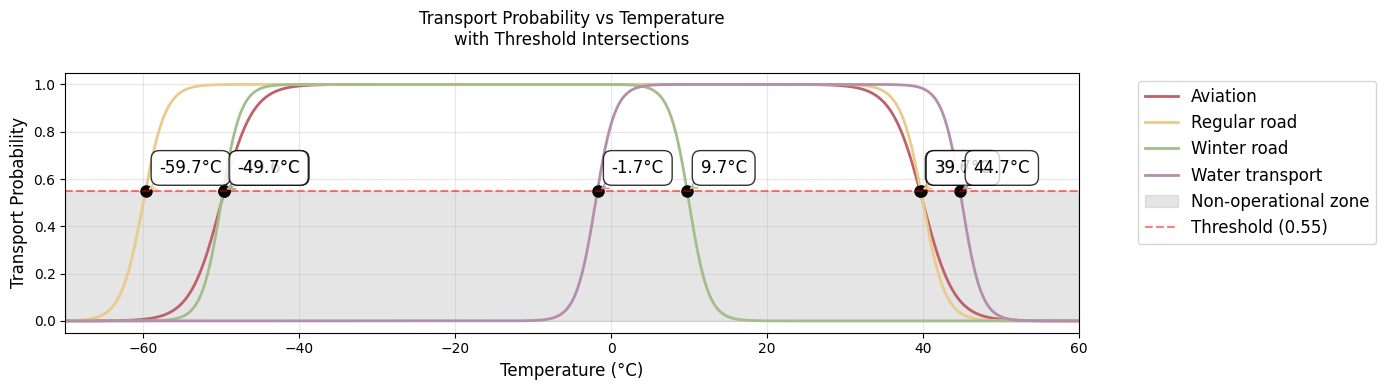

In [ ]:
threshold_temperatures = plot_transport_probability_legacy(
    transport_modes,
    transport_modes_color,
    get_transport_probability,
    threshold,
    temps=None,
    font_size=12,
)


## 2. Main calculations

In [ ]:
# Store results for each settlement and service
all_results = {}
# yakut_chuk
# yanao_kras
# mezen
# nao

data_path = "../data/"
settl_name_lst = ["yakut_chuk"]
range_months = range(12)  # Starting Jan 1982

for SETTL_NAME in settl_name_lst:
    print("=" * 10, SETTL_NAME, "=" * 10)

    # Initialize settlement results
    all_results[SETTL_NAME] = {}
    # service_list
    for SERVICE_NAME in service_list:
        print(" " * 10, SERVICE_NAME, " " * 10)

        CLIMATE_DATA_FILE_NAME = f"df_climate_{SETTL_NAME}.csv"

        settl, df_service, transport_df, infr_df = get_data(
            data_path,
            SETTL_NAME,
            transport_mode_name_mapper,
            transport_modes,
            SERVICE_NAME,
        )
        blocks_gdf = make_block_scheme(settl, df_service, service_name=SERVICE_NAME)
        G_undirected = make_g(transport_df, transport_modes, blocks_gdf, settl)

        df_monthly_list = call_nasa(blocks_gdf, CLIMATE_DATA_FILE_NAME)
        G_undirected = add_temp_to_g(G_undirected, df_monthly_list)

        net = create_agglomeration_network(
            graph=G_undirected,
            threshold=threshold,
            probability_function=get_transport_probability,
            provision_calculator=provision.calculate_graph_provision,
        )

        net.run_all_steps(
            range_months,
            service_radius_minutes=service_radius_minutes[SETTL_NAME],
            base_demand=CONST_BASE_DEMAND,
            service_name=SERVICE_NAME,
            return_assignment=True,
        )

        # Store results for this service
        all_results[SETTL_NAME][SERVICE_NAME] = {
            "net": net,
            "stats": net.stats,
            "graphs": net.stats.graphs,
            "records": net.stats.records,
            "results": net.stats.results,
            "G_undirected": G_undirected,
        }

        # Предполагаем что индекс df_stats — это месяцы в виде `i` (0...len-1)
        df_stats = net.stats.records
        try:
            df_stats["Month"] = df_stats.index % MONTHS_IN_YEAR + 1
            df_stats["Year"] = START_YEAR + df_stats.index // MONTHS_IN_YEAR
        except Exception:
            pass

        df_modes_monthly = create_df_modes_monthly_fixed(
            G_undirected,
            transport_modes,
            threshold_temperatures,
            START_YEAR,
            MONTHS_IN_YEAR=MONTHS_IN_YEAR,
        )

        # Store df_modes_monthly as well
        all_results[SETTL_NAME][SERVICE_NAME]["df_modes_monthly"] = df_modes_monthly


========== yakut_chuk ==========
           post           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 16.27it/s]


           culture           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 16.64it/s]


           health           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 15.43it/s]


           port           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 17.24it/s]


           airport           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 16.85it/s]


           marina           


Running network analysis: 100%|██████████| 12/12 [00:00<00:00, 16.30it/s]


## 3. Multilayer chart

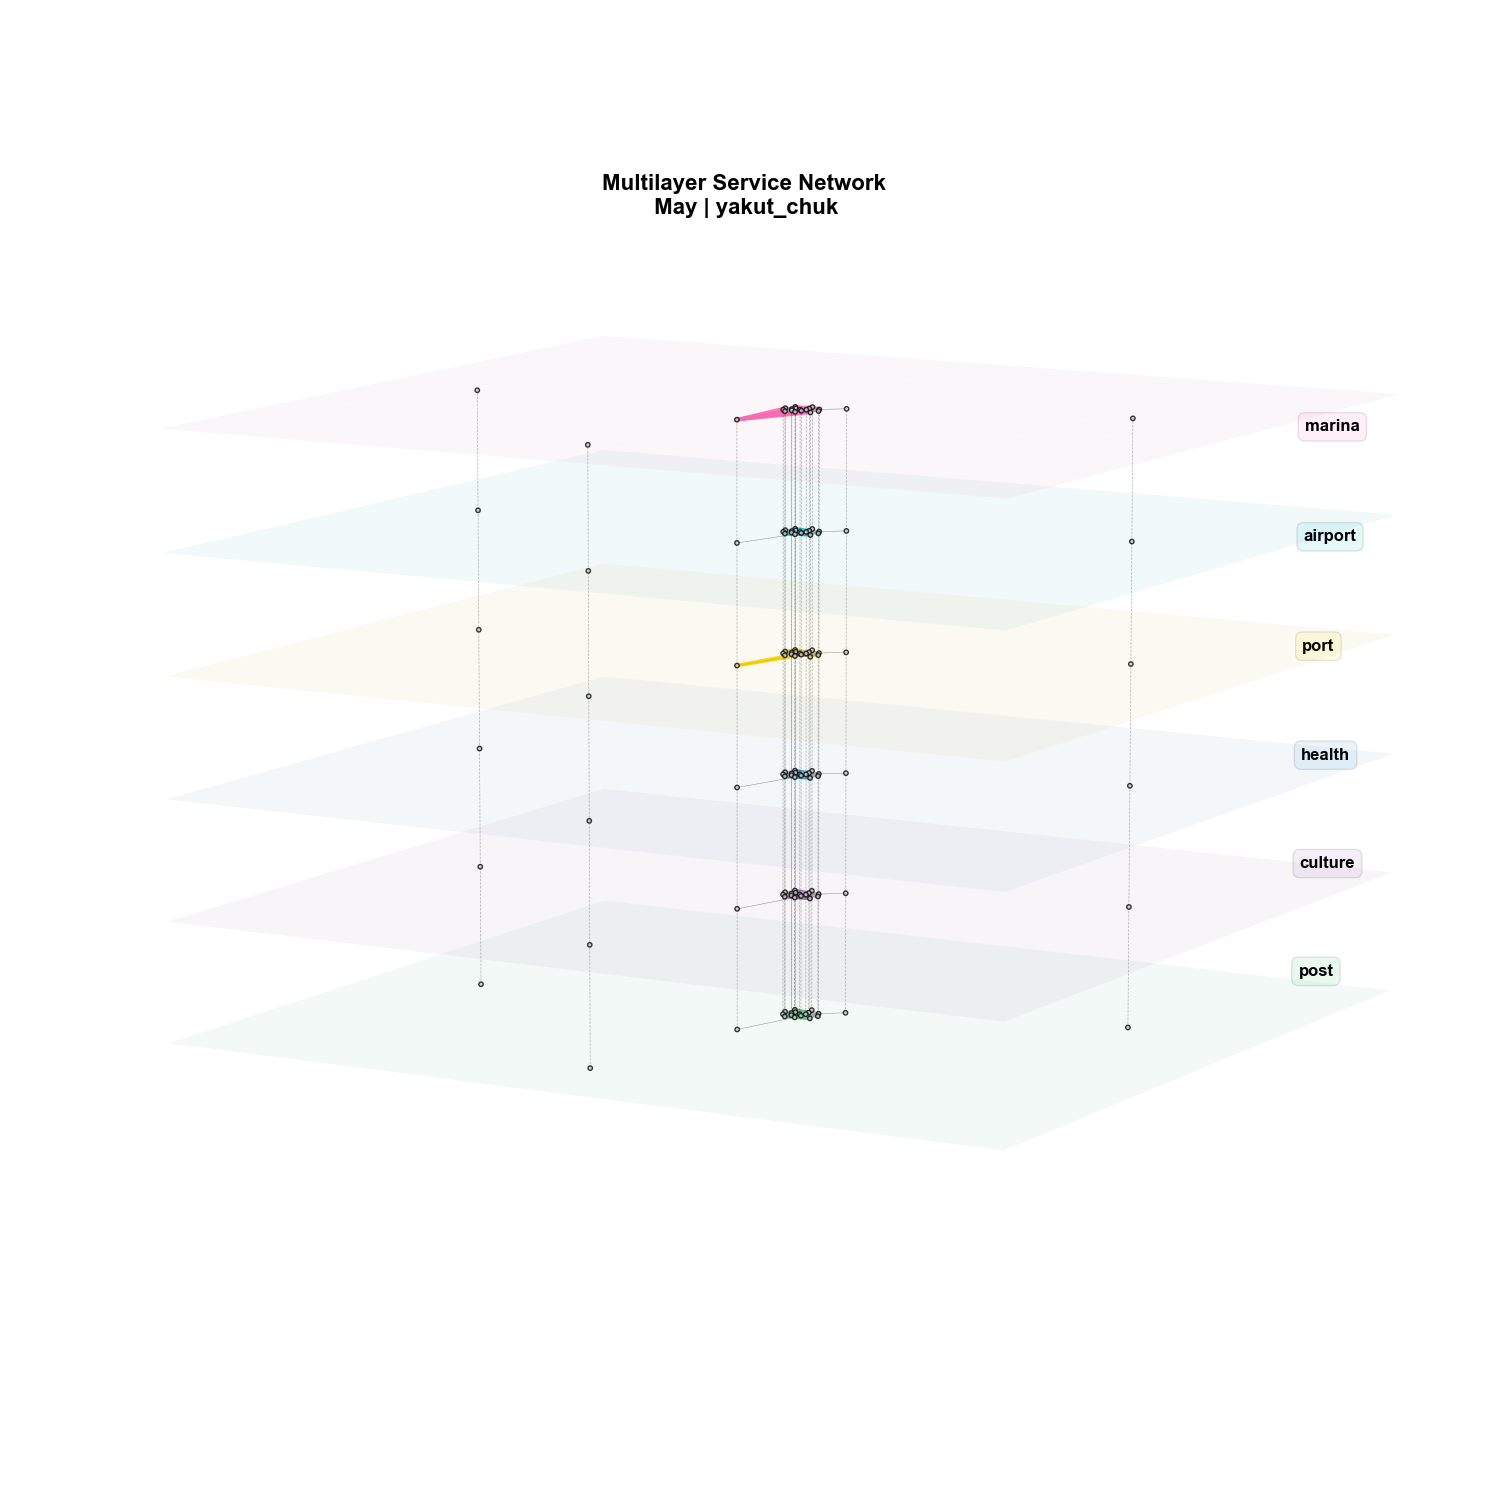

In [ ]:
month = 4

# Example usage:
fig = plot_multilayer_network(
    all_results, SETTL_NAME, service_list, month=month, figsize=(15, 30)
)


# time.sleep(2)  # Pause to ensure the plot is rendered before saving
# plt.savefig(
#     f"../plots/multilayer_network_{SETTL_NAME}_{month_order[month]}.png",
#     bbox_inches="tight",
#     dpi=300,
# )


## 4. Sankey chart

In [ ]:
# for service in service_list:
for service in ["marina"]:
    month_start = 4
    end_month = 10
    graphs = all_results[SETTL_NAME][service]["stats"].graphs[month_start:end_month]
    _ = create_clean_sankey(graphs, service_name=service, month_start=month_start)


Creating Sankey for 6 time periods...
Excluding 4 self-sufficient settlements: ['Anjujsk', 'Jakutsk', 'Cherskij', 'Magadan']
Found 17 consumers
T1: 14 assignments, 3 no provider
T2: 6 assignments, 11 no provider
T3: 6 assignments, 11 no provider
T4: 5 assignments, 12 no provider
T5: 17 assignments, 0 no provider
T6: 14 assignments, 3 no provider
Created 36 nodes
Created 102 flows


## 5. Circular flow chart

In [ ]:
month_n = 5
# for service in service_list:
for service in ["marina"]:
    # graphs = all_results[SETTL_NAME][service]["stats"].graphs[month_start:end_month]
    graphs = all_results[SETTL_NAME][service]["stats"].graphs[month_n : month_n + 1]
    for i, g in enumerate(graphs):
        fig = plot_circular_network_sankey_style(
            g,
            service_name=service,
            month_name=month_order[month_start + i],
        )
        fig.show()


## 6. Service coverage map

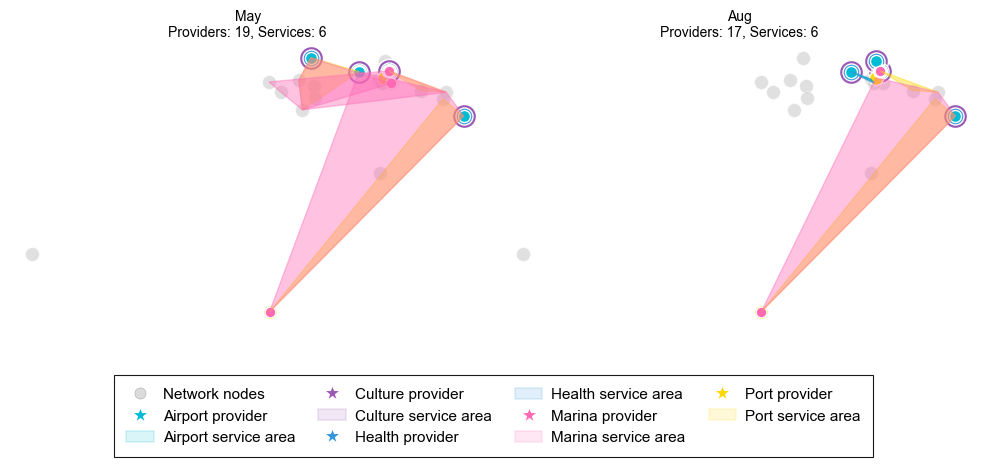

In [ ]:
MONTH_RANGE = range(4, 8, 3)  # May to October (indices 4-9)
results = plot_temporal_service_evolution(all_results, SETTL_NAME, MONTH_RANGE)


## 7. Community evolution charts

/Users/test/Documents/code/iccs25/scripts/plotter/plotter_multi_temporal_nx_plots.py:227: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



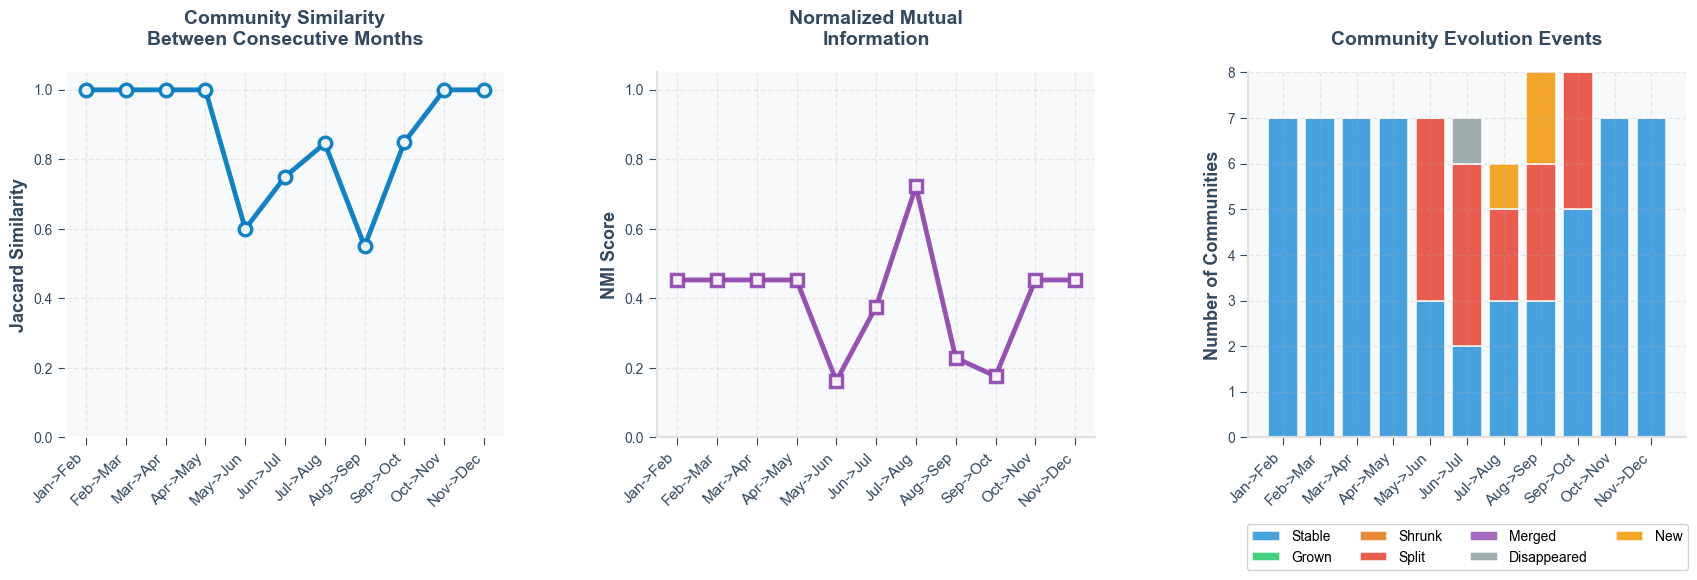

In [ ]:
MONTH_RANGE = range(12)  # May to October (indices 4-9)
metrics, communities = calculate_temporal_metrics(all_results, SETTL_NAME, MONTH_RANGE)
_ = plot_temporal_metrics(metrics, communities)
